In [13]:
# Imports libraries

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras.layers.pooling import GlobalAveragePooling2D
import numpy as np
import seaborn as sns

from tensorflow.keras import Model,layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix

# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3



In [3]:
#Lets get data

train_data = "C:/Users/taka-/Documents/kaggle/rice_crop/NitrogenDeficiencyImage/Training"
test_data = "C:/Users/taka-/Documents/kaggle/rice_crop/NitrogenDeficiencyImage/Test"

In [4]:
from keras.callbacks import EarlyStopping
Callback = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [5]:
# Apply augmentation to data
# augmentation train only
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.15,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   fill_mode = 'nearest'
                                  )

validation_datagen = ImageDataGenerator(rescale = 1./255., validation_split=0.15)

test_datagen = ImageDataGenerator(rescale = 1./255.)

In [6]:
# Getting augmented training and testing images

train_generator = train_datagen.flow_from_directory(directory = train_data, 
                                                     batch_size = 16, 
                                                     target_size = (224,224), 
                                                     class_mode = "categorical", 
                                                     shuffle = True,
                                                     subset='training')

validation_generator = validation_datagen.flow_from_directory(directory = train_data, 
                                                                target_size=(224,224),
                                                                batch_size=16,
                                                                class_mode='categorical',
                                                                shuffle=False,
                                                                subset='validation')  

test_generator = test_datagen.flow_from_directory(directory = test_data,
                                                   batch_size = 16,
                                                   target_size = (224,224),
                                                   class_mode = "categorical",
                                                   shuffle = False)

Found 4582 images belonging to 4 classes.
Found 808 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [7]:
# 全結合層の除去
base_model = InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = None
)

In [8]:
# Create an instance of the inception model from the local pre-trained weights
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [11]:
# 保存していたウエイトをロードする。
pre_trained_model = InceptionV3(include_top=False)
pre_trained_model.load_weights(local_weights_file)

In [ ]:
pre_trained_model = InceptionV3(include_top = False, 
                                weights = 'imagenet',
                                input_shape = None                                
                                )

In [ ]:
# 全結合層の新規構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# ネットワーク定義
model = Model(inputs = base_model.input, outputs = predictions)

# 250層以降を学習させる
for layer in model.layers[:249]:
    layer.trainable = False

    # Batch Normalization の freeze解除
    if layer.name.startswith('batch_normalization'):
        layer.trainable = True

for layer in model.layers[249:]:
    layer.trainable = True

# layer.trainableの設定後に、必ずcompile
model.compile(
    optimizer = Adam(),
    loss = 'categorical_crossentropy',
    metrics = ["accuracy"]
)

In [28]:
history = model.fit(
                    train_generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = Callback,
                    shuffle = True,
                    verbose = 1)

Epoch 1/20
287/287 [==============================] - 85s 215ms/step - loss: 0.3856 - accuracy: 0.8688 - val_loss: 0.5161 - val_accuracy: 0.8243
Epoch 2/20
287/287 [==============================] - 56s 196ms/step - loss: 0.1883 - accuracy: 0.9406 - val_loss: 0.2030 - val_accuracy: 0.9332
Epoch 3/20
287/287 [==============================] - 53s 185ms/step - loss: 0.1141 - accuracy: 0.9664 - val_loss: 0.0297 - val_accuracy: 0.9901
Epoch 4/20
287/287 [==============================] - 57s 197ms/step - loss: 0.0786 - accuracy: 0.9747 - val_loss: 0.0513 - val_accuracy: 0.9777
Epoch 5/20
287/287 [==============================] - 64s 224ms/step - loss: 0.0847 - accuracy: 0.9712 - val_loss: 0.0631 - val_accuracy: 0.9765
Epoch 6/20
287/287 [==============================] - 54s 189ms/step - loss: 0.0633 - accuracy: 0.9801 - val_loss: 0.0097 - val_accuracy: 0.9988
Epoch 7/20
287/287 [==============================] - 56s 195ms/step - loss: 0.0721 - accuracy: 0.9764 - val_loss: 0.0225 - val_ac

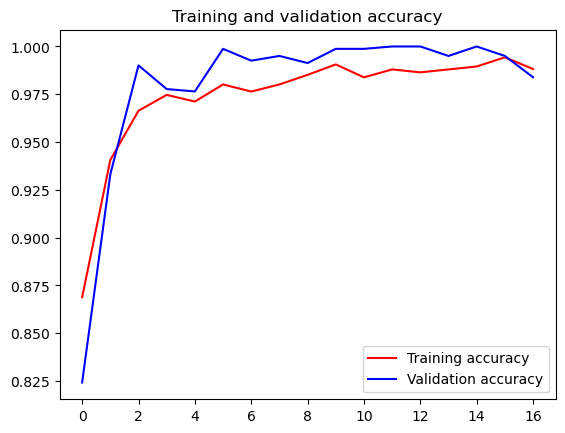

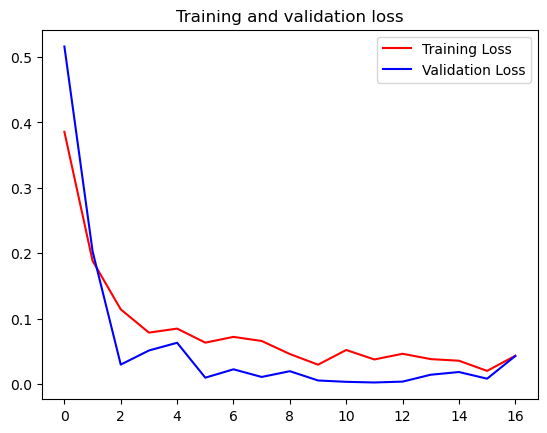

<Figure size 640x480 with 0 Axes>

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

In [31]:
# 学習済みモデルを保存
model.save('model_fine.h5')

#重みは学習済みモデルと一緒に保存される。保存したくないときはFalseにする
# model.save('model.h5', include_optimizer=False)

25/25 [==============================] - 4s 76ms/step


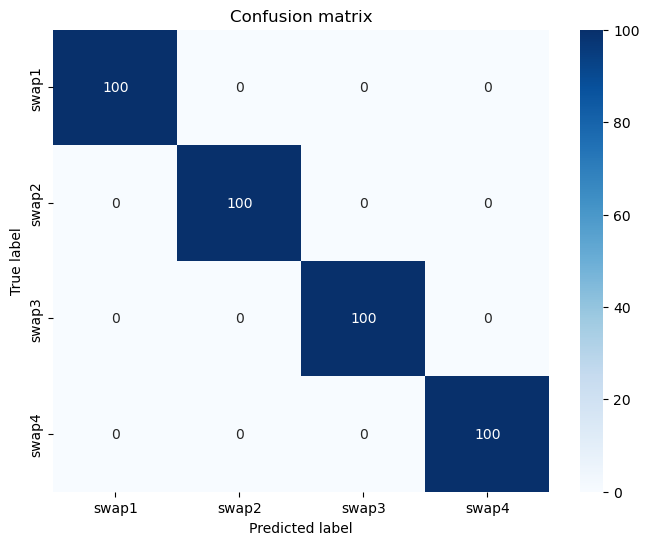

In [32]:
# Confusion matrix
y_pred = np.argmax(model.predict(test_generator), axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
classes = list(train_generator.class_indices.keys())

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cbar=True, cmap='Blues',xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [33]:
# 検証
# Evaluate on test dataset
score = model.evaluate(test_generator, verbose=True)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

25/25 [==============================] - 2s 80ms/step - loss: 3.7086e-04 - accuracy: 1.0000
Test loss: 0.0003708646399900317
Test accuracy: 1.0
